In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize, least_squares
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage

In [2]:
# name = "T_S04856"
# name = "T_S04912"
name = "T_S04923"

png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [3]:
clusters = 10

In [4]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [5]:
def imshow(img: np.ndarray, color_channel="rgb"):
    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

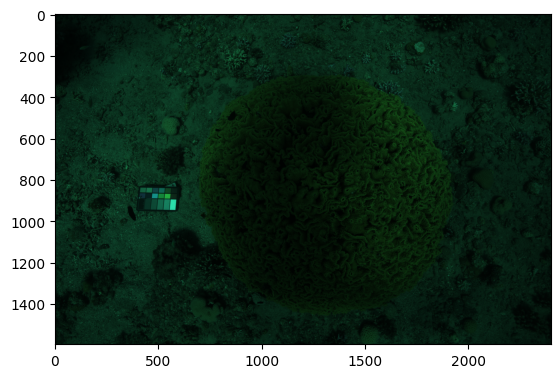

In [6]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [7]:
png.dtype

dtype('float64')

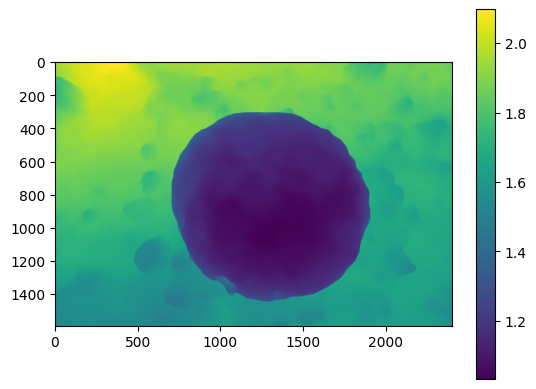

In [8]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [9]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [10]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [11]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

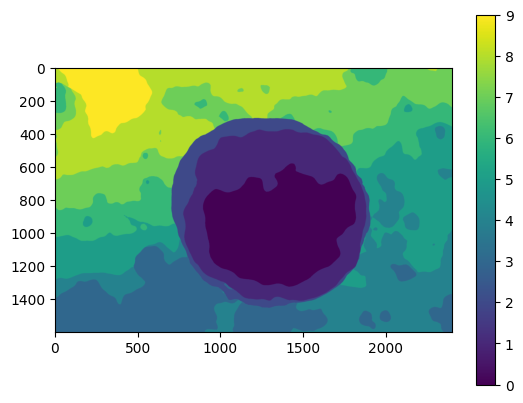

In [12]:
kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
labels = np.zeros(tif_flat.shape, dtype=np.uint8)
labels[tif_flat != 0] = kmeans.labels_
labels[tif_flat == 0] = 255 # Use 255 to represent nan
means = np.array(kmeans.cluster_centers_).flatten()
means_args = np.argsort(means)

labels_new = np.zeros_like(labels)
labels_new[labels == 255] = clusters + 1

for current_label in range(clusters):
    new_label = np.nonzero(means_args == current_label)[0]
    labels_new[labels == current_label] = new_label

labels = labels_new.reshape((height, width))
imshow(labels)

In [13]:
dark_pixels = []
z_values = []

for i in range(clusters):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [14]:
dark_pixels.shape, z_values.shape

((48789, 3), (48789,))

In [15]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [16]:
z_values

array([1.11736989, 1.11718369, 1.11463082, ..., 2.01135969, 2.01256084,
       2.01059484], shape=(48789,))

In [17]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [18]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return np.sum((B_hat - estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z)) ** 2)

In [19]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=10):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [20]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.73501968 0.36420486 0.75901013 1.0809895 ]
0.774582855156446 [0.34694024 0.02181809 0.05029752 4.77592017]
[0.49702912 3.94825518 0.72189662 2.79885513]
2.0872647340678467 [0.01093787 1.57258172 0.23608831 3.8992279 ]
[0.58850391 3.68494672 0.66836219 0.70509961]
2.1801718600193962 [0.00972021 4.65548659 0.07969964 3.16703068]
[0.49001222 3.8914377  0.78581709 0.15072271]
0.7653477917858789 [0.16530902 0.04681386 0.00581003 3.44179432]
[0.11224335 2.45546294 0.45275201 1.29630473]
1.3871779520845786 [0.01222895 1.58086322 0.0523073  4.8837212 ]
[0.83635168 3.58318935 0.30422524 3.32760547]
1.3907437727203567 [0.01542533 0.80199964 0.13629366 4.04148321]
[0.6292251  4.90446508 0.09273439 3.22039617]
1.875676902929258 [0.0103636  4.89099085 0.04271797 3.31056114]
[0.12313565 2.20550924 0.27768665 4.61807935]
1.7747512965271908 [0.01097742 2.13882614 0.228582   4.63759637]
[0.16944775 2.1125877  0.96237422 4.43165665]
1.9552795764395663 [0.01641298 0.62311175 0.5076377  4.35518466]
[0.

(array([0.16530902, 0.04681386, 0.00581003, 3.44179432]),
 np.float64(0.7653477917858789))

In [21]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.83263961 0.07102204 0.17489337 1.27670391]
1.2321942776838757 [0.79976743 0.01514521 0.0947768  3.79221275]
[0.96633354 1.17699789 0.22114347 3.82611304]
1.8222154388705503 [0.02741762 0.71994337 0.14943088 3.91231377]
[0.12184193 1.51369875 0.83019712 3.31248341]
3.4876495607741758 [0.01878313 1.38674707 0.44287058 3.87624442]
[0.36255749 4.74084373 0.8827622  1.48351844]
1.2556967739373608 [0.12828271 0.10119176 0.08828441 3.86372072]
[0.22037156 1.09649412 0.59559226 0.68961874]
1.5206395401238788 [0.03530609 0.48974961 0.22833119 4.7131056 ]
[0.24576153 2.83579505 0.9875015  4.1868425 ]
3.9783982769812183 [0.01647149 2.75299732 0.71272051 4.39145059]
[0.05047961 2.44644937 0.57412985 0.18616663]
2.82680965621394 [0.01771571 3.30348146 0.10749354 3.69307528]
[0.42480898 2.78347323 0.38035243 1.88228112]
3.179589348547262 [0.01711725 2.7051657  0.0761936  2.72972675]
[0.60636656 1.9293323  0.20068613 3.34284608]
2.4475922938719004 [0.01877759 2.14723351 0.1163781  4.07108395]
[0.5

(array([0.79976743, 0.01514521, 0.0947768 , 3.79221275]),
 np.float64(1.2321942776838757))

In [22]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.56087053 4.21777527 0.89093657 2.44594628]
0.2587926067189556 [3.29069954e-03 5.54585320e-01 1.30466454e-01 4.05561869e+00]
[0.40153664 3.01988076 0.55024368 2.00635213]
0.3547680930280061 [1.37089133e-03 2.97807466e+00 1.20921227e-01 3.68261204e+00]
[0.10298587 0.52487859 0.63044486 4.5307357 ]
0.20466411458427025 [0.00835111 0.19048489 0.16459901 4.63107958]
[0.96531105 1.1283807  0.56539651 0.02279503]
0.16807133220733977 [4.20967542e-03 5.08562946e-01 5.43027714e-02 4.49570384e+00]
[0.79950436 0.14776028 0.75801951 0.05862679]
0.3286197509198935 [5.02293260e-01 2.20372529e-03 2.25856146e-01 4.13990626e+00]
[0.68697751 2.83717288 0.16937705 4.21428982]
0.23753586753016961 [2.13244109e-03 1.64204788e+00 9.43970413e-02 4.17848166e+00]
[0.1155711  3.53309678 0.66918448 2.40871933]
0.132064184928383 [3.77437443e-02 4.30173904e-02 1.23539715e-03 3.99559752e+00]
[0.56513443 2.88136592 0.32053794 3.69768004]
0.2838705168059201 [2.02410293e-03 1.23835167e+00 8.02176060e-02 3.54935018e+00

(array([3.77437443e-02, 4.30173904e-02, 1.23539715e-03, 3.99559752e+00]),
 np.float64(0.132064184928383))

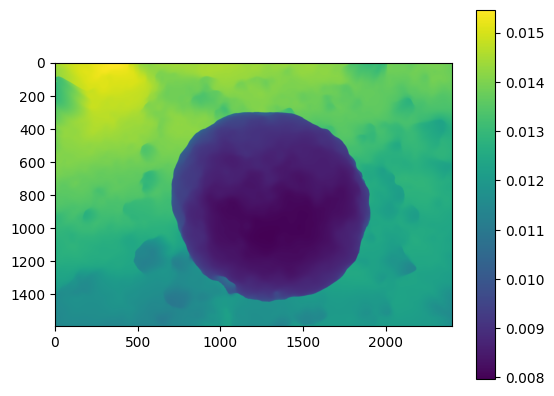

In [23]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

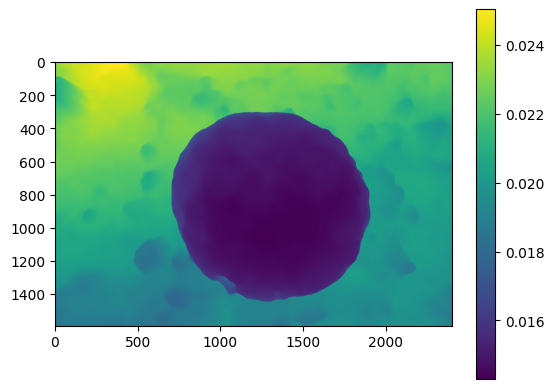

In [24]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

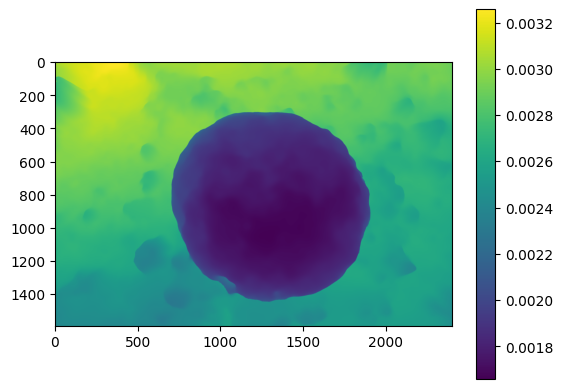

In [25]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

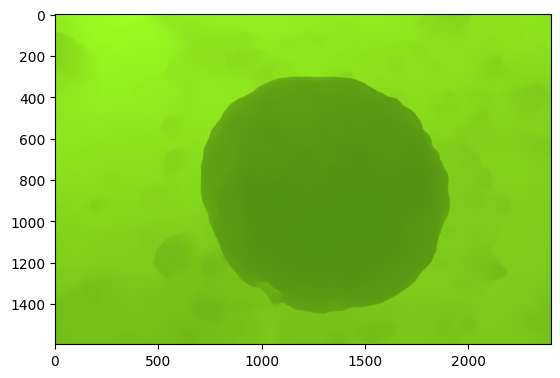

In [26]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01176731938786767..0.8692857436719683].


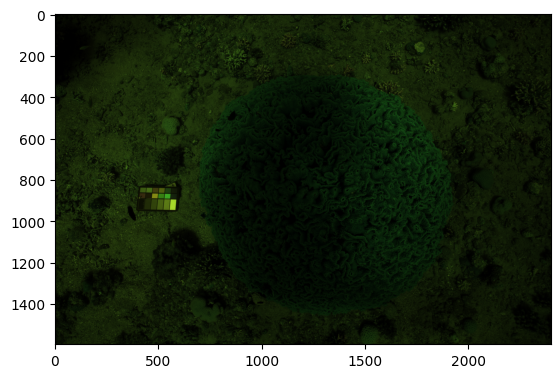

In [27]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

plt.imshow(direct_signal)

In [28]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [29]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0

In [30]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.1065607)

In [31]:
import collections

def construct_neighborhood_map(depths, epsilon=0.05):
    eps = epsilon
    nmap = np.zeros_like(depths).astype(np.int32)
    n_neighborhoods = 1
    while np.any(nmap == 0):
        locs_x, locs_y = np.where(nmap == 0)
        start_index = np.random.randint(0, len(locs_x))
        start_x, start_y = locs_x[start_index], locs_y[start_index]
        q = collections.deque()
        q.append((start_x, start_y))
        while not len(q) == 0:
            x, y = q.pop()
            if np.abs(depths[x, y] - depths[start_x, start_y]) <= eps:
                nmap[x, y] = n_neighborhoods
                if 0 <= x < depths.shape[0] - 1:
                    x2, y2 = x + 1, y
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
                if 1 <= x < depths.shape[0]:
                    x2, y2 = x - 1, y
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
                if 0 <= y < depths.shape[1] - 1:
                    x2, y2 = x, y + 1
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
                if 1 <= y < depths.shape[1]:
                    x2, y2 = x, y - 1
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
        n_neighborhoods += 1
    zeros_size_arr = sorted(
        zip(*np.unique(nmap[depths == 0], return_counts=True)),
        key=lambda x: x[1],
        reverse=True,
    )
    if len(zeros_size_arr) > 0:
        nmap[nmap == zeros_size_arr[0][0]] = 0  # reset largest background to 0
    return nmap, n_neighborhoods - 1


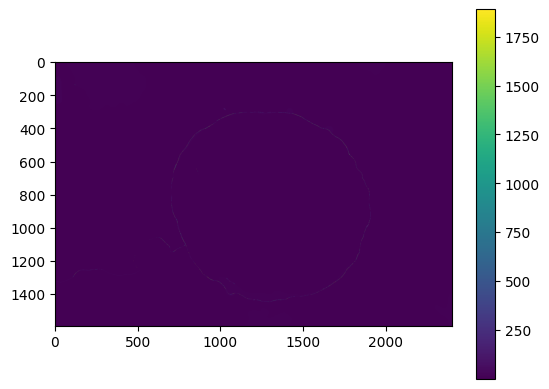

In [32]:
neighborhoods, _ = construct_neighborhood_map(tif, epsilon=epsilon)

imshow(neighborhoods)

In [33]:
# neighborhoods2 = np.load("./neighborhood_map.npz")["neighborhood_map"]
# # neighborhoods2[neighborhoods2 > 500] = 0

# imshow(neighborhoods2)

In [34]:
def update_a_prime(a_values: np.ndarray, neighborhood_map:np.ndarray):
    max_class = neighborhood_map.max()

    a_prime = np.zeros_like(a_values)
    for i in range(1, max_class + 1):
        selected_cells = neighborhood_map == i
        if not np.any(selected_cells):
            continue

        a_prime[selected_cells, 0] = a_values[selected_cells, 0].mean()
        a_prime[selected_cells, 1] = a_values[selected_cells, 1].mean()
        a_prime[selected_cells, 2] = a_values[selected_cells, 2].mean()

    return a_prime

def update_a_values(D: np.ndarray, a_prime: np.ndarray, p: float = 0.1):
    return D * p + a_prime * (1 - p)

In [35]:
a_values = np.zeros((height, width, 3), dtype=np.float64) # We have more than one class than the total count b/c we did not use 0
prev_a_values = np.ones_like(a_values)

while np.any(np.abs(a_values - prev_a_values) >= convergence_threshold):
    print(np.abs(a_values - prev_a_values).max())

    prev_a_values = a_values

    a_prime = update_a_prime(a_values, neighborhoods)
    a_values = update_a_values(direct_signal, a_prime)

1.0
0.08692857436719684
0.03021868795089394
0.027196819155804547
0.024477137240224087
0.022029423516201685
0.019826481164581494
0.01784383304812337
0.016059449743311027
0.014453504768979941
0.013008154292081908
0.011707338862873728
0.010536604976586372
0.009482944478927724
0.008534650031034985
0.00768118502793147
0.0069130665251382895
0.006221759872624466
0.005599583885362025
0.00503962549682585
0.004535662947143249
0.004082096652428924
0.0036738869871860147
0.0033064982884674077
0.002975848459620678
0.002678263613658638
0.0024104372522927298
0.002169393527063468
0.0019524541743571322
0.0017572087569214245
0.0015814878812292488
0.001423339093106324
0.0012810051837957026
0.0011529046654161212
0.001037614198874548


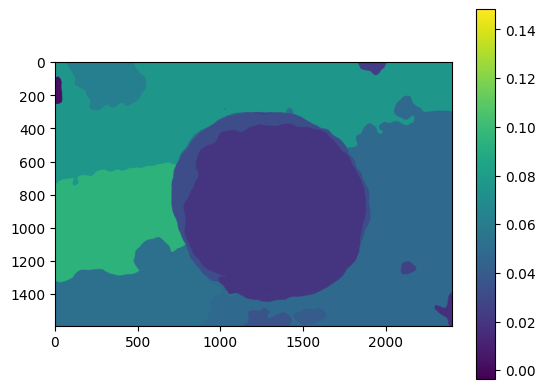

In [36]:
imshow(a_prime[:, :, 0])

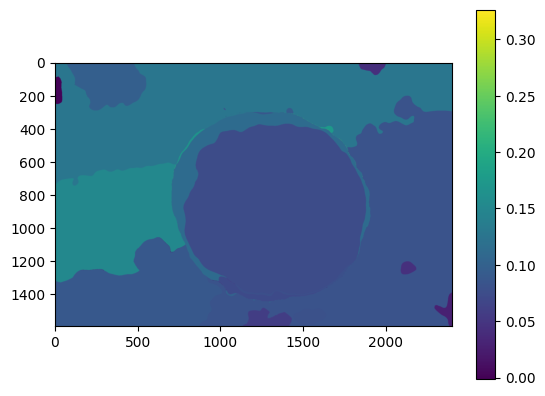

In [37]:
imshow(a_prime[:, :, 1])

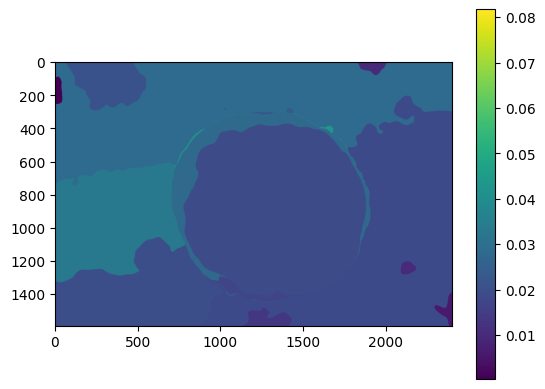

In [38]:
imshow(a_prime[:, :, 2])

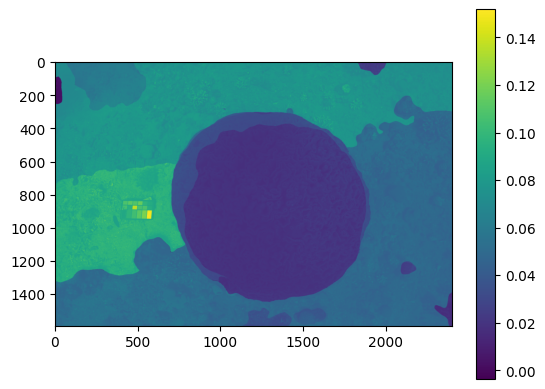

In [39]:
imshow(a_values[:, :, 0])

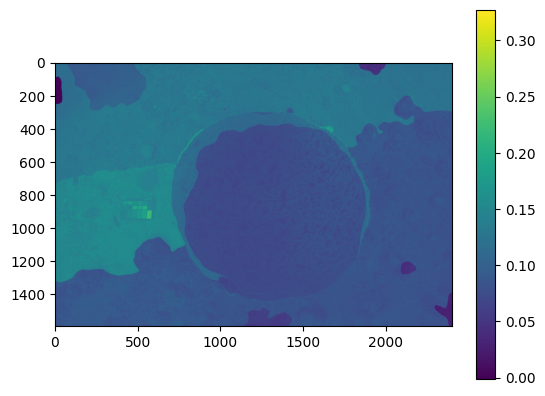

In [40]:
imshow(a_values[:, :, 1])

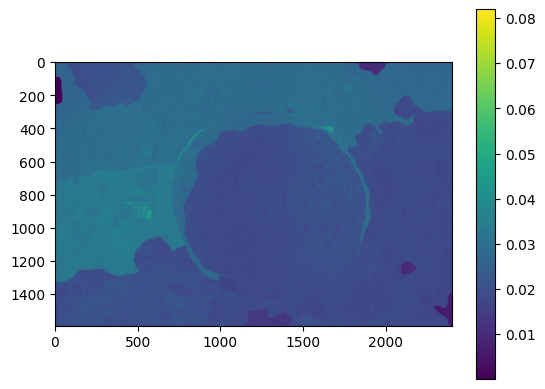

In [41]:
imshow(a_values[:, :, 2])

0.6547170488869866


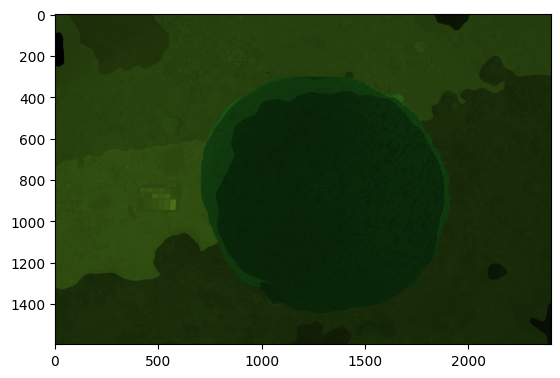

In [42]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map)

/tmp/ipykernel_201254/4189907836.py:3: RuntimeWarning: invalid value encountered in log
  beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
/tmp/ipykernel_201254/4189907836.py:4: RuntimeWarning: invalid value encountered in log
  beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
/tmp/ipykernel_201254/239008167.py:5: RuntimeWarning: invalid value encountered in cast
  return (array * 255).astype(np.uint8)


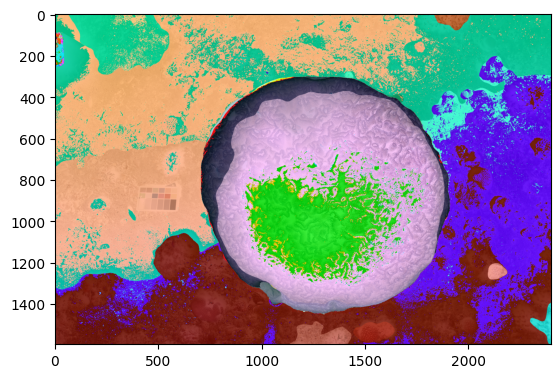

In [43]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

imshow(beta_d_coarse)

### Refined Estimate of $\beta_c^D(z)$

In [44]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [45]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> np.ndarray[float]:
    a, b, c, d = args
    beta_D = compute_beta_D(a, b, c, d, z)
    z_hat = -np.log(E) / beta_D

    return (z - z_hat).flatten()

In [46]:
def leastsquares_compute_beta_D(local_illuminant_map: np.ndarray, depths: np.ndarray, color_channel: int, starts=50):
    lo = np.array([0, -np.inf, 0, -np.inf])
    hi = np.array([np.inf, 0, np.inf, 0])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4) * 2000
        starting_point[1] /= -10
        starting_point[3] /= -10

        print(starting_point)

        try:
            result = least_squares(optimize_compute_beta_D, starting_point, args=(local_illuminant_map[:, :, color_channel], depths), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        result = optimize_compute_beta_D(params, local_illuminant_map[:, :, color_channel], depths)
        max_diff = np.abs(result).max()
        loss = (np.abs(result)).mean()

        print(loss, max_diff, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [47]:
local_illuminant_params_b, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 0)

local_illuminant_params_b, loss #0.106

[ 905.30175697 -107.83792197  930.90483088  -85.2813253 ]
[1864.01304052  -41.93424404 1704.05029649   -2.7078714 ]


/tmp/ipykernel_201254/1999039822.py:4: RuntimeWarning: invalid value encountered in log
  z_hat = -np.log(E) / beta_D


[599.4583986  -13.55247651 967.67909887 -34.30663156]
[ 356.5900634  -177.99680654  905.79444912 -118.95951059]
[  66.32548714 -178.54485    1013.51591071 -100.52260089]
[ 188.9259563   -91.12776075 1686.23839943  -50.79412325]
[ 573.08482814 -143.15880051    7.63657512 -167.91606419]
[ 665.09840334 -181.76072459 1634.58780081 -166.33467259]
[ 1.89091507e+03 -7.10792921e-01  1.61605535e+03 -1.39519307e+02]
[439.27630374 -92.58160879 335.99482778 -57.38274092]
[1667.01447986  -71.57302919 1736.23809301 -195.10130629]
[1310.86333739 -161.97712157  789.19807488  -93.96834307]
[1960.49425637 -133.88287463  452.75945874  -19.66699019]
[ 372.65438397 -176.16503073 1466.11139393 -118.52516252]
[1481.02033203  -89.03378427 1638.88167675 -120.0630355 ]
[  6.53544122 -52.51045488 770.42170955 -74.2855837 ]
[ 441.54119763  -36.40429248 1301.00477648 -135.67487266]
[1643.19618867  -23.23165057 1009.63207762 -139.84842006]
[388.22328784 -87.65672471 417.35540599  -1.52560831]
[ 895.11752912  -73.83

(None, None)

In [48]:
local_illuminant_params_g, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 1)

local_illuminant_params_g, loss #0.160

[ 752.89653771 -134.7722317   333.18168498 -118.33196234]
[1437.12346818 -159.88343232 1672.67414649 -143.24849604]
[ 524.93062191 -187.29573635 1428.79783418 -150.92443631]


/tmp/ipykernel_201254/1999039822.py:4: RuntimeWarning: invalid value encountered in log
  z_hat = -np.log(E) / beta_D


[1075.27816651 -191.91026069 1380.57214185 -159.64646558]
[ 602.4325732  -156.19391341 1039.11168187 -147.66689101]
[ 617.42777394  -59.85028757 1817.9778098  -170.77849547]
[ 455.50818464 -134.83565387 1310.98986092 -186.20548441]
[ 919.91999484  -44.21273263 1086.47425994 -176.18674899]
[1896.22326472  -18.96023847  266.75685201  -88.69010225]
[ 456.34091782 -185.91501536  334.58704265 -157.54107524]
[ 105.70193492  -67.16579536  522.11963365 -153.00403656]
[ 109.12935918 -102.5601471   545.6770829   -16.59775965]
[1872.84699414 -122.72642352  119.74837249   -7.26084051]
[ 973.70316944 -100.93530919  291.79320442 -159.10626332]
[1755.11964191  -54.9280795   890.06821792 -113.70388882]
[1442.82013495  -46.54461267 1649.56607253  -18.53045495]
[ 480.66933081 -146.69467158 1286.98323589  -52.31793917]
[ 567.23966269  -29.97322998 1694.6954046  -177.44199804]
[1941.16919399 -168.50120919  491.9483395   -64.65642923]
[ 192.52321283  -87.48750412  921.18509875 -158.2172159 ]
[ 582.23672563

(None, None)

In [49]:
local_illuminant_params_r, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 2)

local_illuminant_params_r, loss #0.0769

[ 979.09362637 -111.60388078  938.48181189 -158.02282138]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:141: RuntimeWarning: invalid value encountered in scalar multiply
  alpha = max(0.001 * alpha_upper, (alpha_lower * alpha_upper)**0.5)
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/chris/.cache/

1.3888744803124903e+96 1.569726554314439e+99 [ 979.09362637 -111.60388078  938.48181189 -158.02282138]
[  76.3009857   -17.44356926 1846.81441767   -9.4451865 ]
0.08911185068939903 4.451217424622038 [ 2.06572925e+05 -6.14117181e+06  7.17660083e+00 -8.01873673e-01]
[1561.09351156   -3.97069917  462.32267508 -165.12708493]
0.08911124942060272 4.451221221918291 [   7.17671806   -0.80188318  462.32267508 -165.12708493]
[ 494.90501928 -166.15497275 1344.75898491 -186.89546374]
8.731931461169296e+145 1.5476765185334047e+149 [ 494.90501928 -166.15497275 1344.75898491 -186.89546374]
[1269.13283123  -12.00097468 1486.75750607 -179.29202201]
0.08911244701674607 4.451213742675203 [ 7.17648403e+00 -8.01864214e-01  1.48675751e+03 -1.79292022e+02]
[1903.56121635  -92.00855116 1950.64792702  -87.33497238]
7.30361056180568e+73 6.12067086932378e+76 [1903.56121635  -92.00855116 1950.64792702  -87.33497238]
[ 685.95037956 -139.86436186   76.07939319 -126.44522641]
5.13275704150244e+110 6.702820853948067e

/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


145804.4073441034 65908834.14560938 [ 3.22365810e+43 -5.57775237e+01  1.20578059e+03 -1.54847902e+02]
[ 559.35566499 -147.93597513  585.8939719  -151.94756537]
2.2167668996241783e+129 3.4546372178670353e+132 [ 559.35566499 -147.93597513  585.8939719  -151.94756537]
[ 387.32787441  -44.02709412 1137.79290362 -106.68040141]
327302.81177174643 100273684.21749263 [ 9.56011904e+31 -4.33238488e+01  1.13779290e+03 -1.06680401e+02]
[ 767.91368426 -131.39903994 1097.73715571 -102.75489171]
1.1856669189472772e+88 1.2147195961270034e+91 [ 767.91368426 -131.39903994 1097.73715571 -102.75489171]
[1439.86156951 -100.48193924 1504.78228445 -180.63840195]
7.891268161944651e+85 7.869209004461692e+88 [1439.86156951 -100.48193924 1504.78228445 -180.63840195]
[1267.88598345 -190.16571152  912.31232557  -60.32791347]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = phi / phi_prime


1.490419448421173e+32 7.268909684440503e+34 [ 1.26788598e+03 -1.75774567e+14  1.44097245e+19 -5.87333421e+01]
[ 893.39011314  -12.77895073 1299.43740999  -53.3689909 ]
0.08911162261088967 4.451218778359061 [ 7.17664592e+00 -8.01877318e-01  1.29943741e+03 -5.33689909e+01]
[638.73744288 -22.86695931 530.69685091 -21.43840558]
1.509684723765974 6.737600279708161 [ 1.90927308e+17 -2.64154652e+01  3.87975387e+17 -1.97827155e+01]
[  91.60024905 -138.92519406  969.11272866 -150.32217338]
8.975570084439202e+121 1.3038383673111837e+125 [  91.60024905 -138.92519406  969.11272866 -150.32217338]
[1417.97269644 -172.68420092  808.88593905  -66.35692219]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in scalar divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


6.489218740735109e+54 3.768480182100724e+57 [1417.97269644 -172.68420092 2450.47943941  -66.35692219]
[1234.21743779 -149.64636134  232.07154416  -19.62299318]
1.4944189504376306 7.812414201683904 [ 1.23421744e+03 -3.14360546e+14  1.12282070e+16 -1.81486962e+01]
[  65.13006417 -133.81558267  565.99126571  -39.46060932]
1.5775445582088683 2.09777569770813 [ 6.51300642e+01 -4.97222601e+16  1.24385924e+25 -2.88951937e+00]
[1254.69155065 -189.84110249  456.6867411  -153.60064913]
3.77073503937256e+134 6.126995276627295e+137 [1254.69155065 -189.84110249  456.6867411  -153.60064913]
[1843.07003459  -25.88644951 1450.09851212 -120.97439641]
85476.79391811632 10101749.376770338 [ 2.06555668e+16 -2.50343751e+01  1.45009851e+03 -1.20974396e+02]
[ 586.28411908 -182.25966174 1861.01709032 -156.30657864]
2.6488724861226156e+136 4.38825864830801e+139 [ 586.28411908 -182.25966174 1861.01709032 -156.30657864]
[ 627.97883822 -191.04325148 1451.11329459 -137.63634645]
3.8338034164337115e+119 5.511163144

/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale


[1515.1644433  -126.42286697  353.57209787 -163.39245182]
2.459662726046499e+109 3.2114030532613477e+112 [1515.1644433  -126.42286697  353.57209787 -163.39245182]
[1446.77798029 -158.48053152  465.24673216 -189.57385364]
3.208468193408858e+138 5.397242174367655e+141 [1446.77798029 -158.48053152  465.24673216 -189.57385364]
[ 1.53598155e+02 -1.18173628e+02  1.35781242e+03 -1.54786074e-01]
0.08911185470041928 4.451217387968214 [ 153.59815509 -139.43509851    7.17660013   -0.80187362]
[356.29815743 -51.68324189 902.64800801 -76.76834588]
279102.2404796871 109827346.62713768 [ 6.45001038e+38 -5.08632693e+01  9.02648008e+02 -7.67683459e+01]
[ 1.84377123e+03 -1.61895390e+01  3.25624866e+02 -4.81689290e-01]
0.08911184748610225 4.451217454653885 [ 1.69590867e+03 -1.63859063e+02  7.17660139e+00 -8.01873719e-01]
[1697.09140137 -156.27357116  343.67411183  -66.34813023]
7.498547797670178e+54 4.3538187186136846e+57 [1697.09140137 -156.27357116 2082.27093022  -66.34813023]
[1638.63087712 -180.43547

/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  p *= Delta / norm(p)
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)


6.873748136249907e+62 4.699918572941127e+65 [853.73004069 -74.74085378 532.4318971  -85.33097271]
[1071.96095777 -107.14097859 1048.87376967  -30.09026103]
129481139.6926592 19357676495.335484 [ 1.07196096e+03 -3.43744476e+10  1.32514401e+16 -2.84258007e+01]
[ 868.10004384 -135.46693783 1759.05871746  -52.62259025]
1.2661893924640032e+22 5.000208773235997e+24 [ 8.68100044e+02 -6.23059361e+08  1.81712288e+22 -5.09819282e+01]
[1412.72288363 -143.68178986 1396.78858968  -91.97231723]
1.6035254055027516e+78 1.4342342741580237e+81 [1412.72288363 -143.68178986 1396.78858968  -91.97231723]
[ 700.62040277  -68.87760652 1621.33605346  -38.35087599]
1.6267849919116233 34.56069656358985 [ 7.00620403e+02 -1.01033500e+16  1.71201855e+25 -2.88523144e+01]
[ 999.73088573 -105.9326024   288.04681027  -59.96466795]
2.1255919631510973e+34 1.0069483051652849e+37 [ 9.99730886e+02 -1.73517455e+10  9.20800834e+15 -5.75775571e+01]
[ 998.7960072  -181.54719347 1968.54159896 -193.21731384]
[1170.42206213 -123.3

(array([   7.17671806,   -0.80188318,  462.32267508, -165.12708493]),
 np.float64(0.08911124942060272))

In [50]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(local_illuminant_params_b[0], local_illuminant_params_b[1], local_illuminant_params_b[2], local_illuminant_params_b[3], tif)
beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

imshow(beta_d)

TypeError: 'NoneType' object is not subscriptable

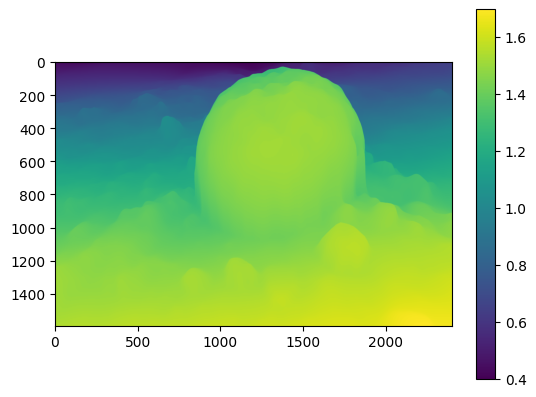

In [ ]:
imshow(beta_d[:, :, 0])

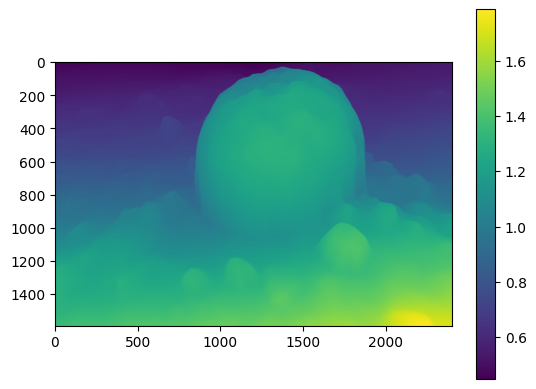

In [ ]:
imshow(beta_d[:, :, 1])

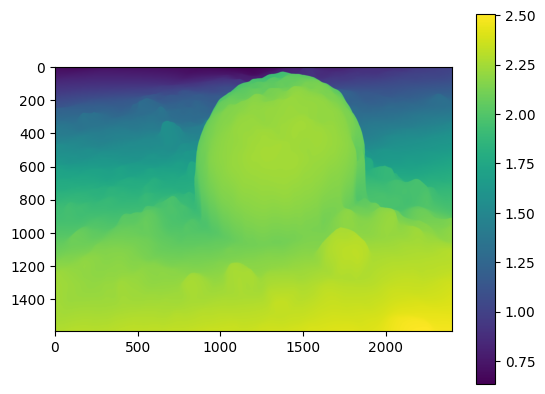

In [ ]:
imshow(beta_d[:, :, 2])

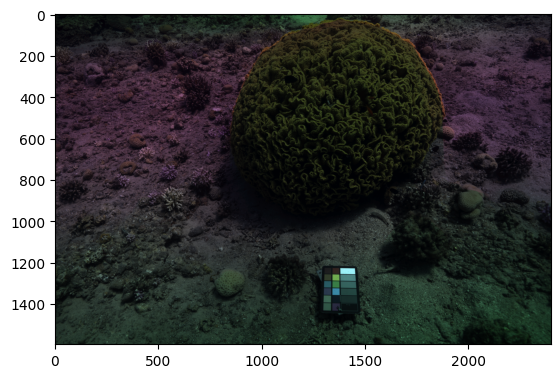

In [ ]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

# J[:, :, 0] = J[:, :, 0] / J[:, :, 0].max()
# J[:, :, 1] = J[:, :, 1] / J[:, :, 1].max()
# J[:, :, 2] = J[:, :, 2] / J[:, :, 2].max()

J = J / J.max()

imshow(J, color_channel="bgr")

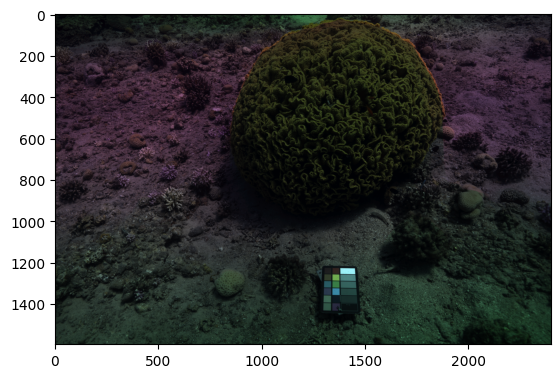

In [ ]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [56]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [57]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

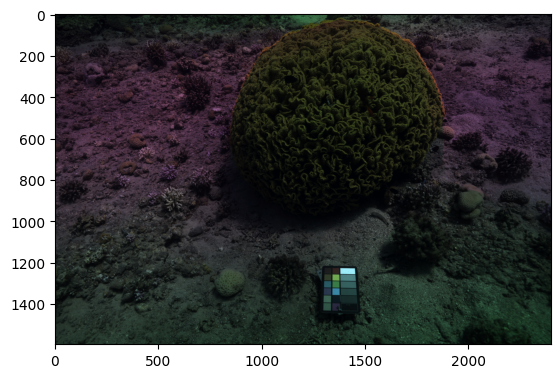

In [ ]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [59]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

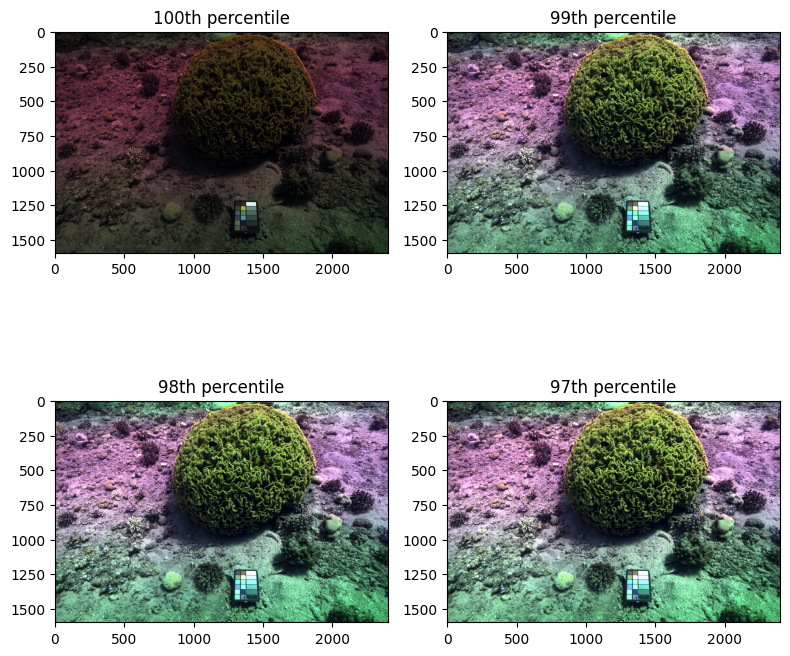

In [ ]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

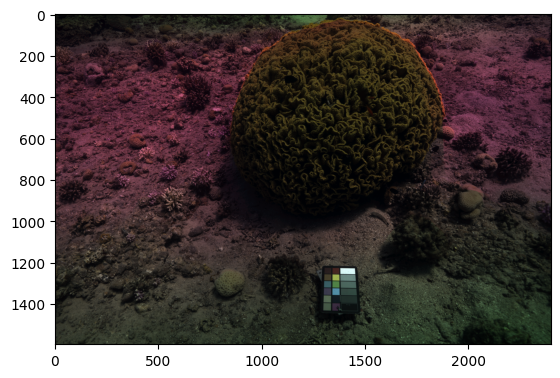

In [ ]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

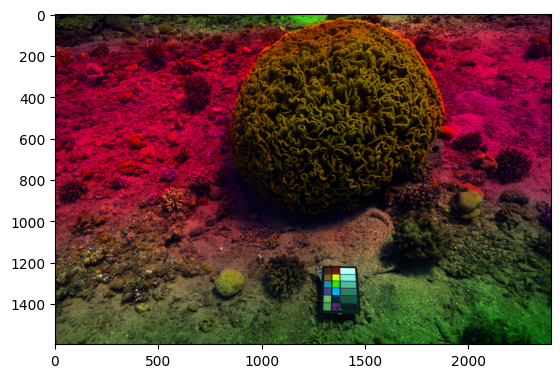

In [ ]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

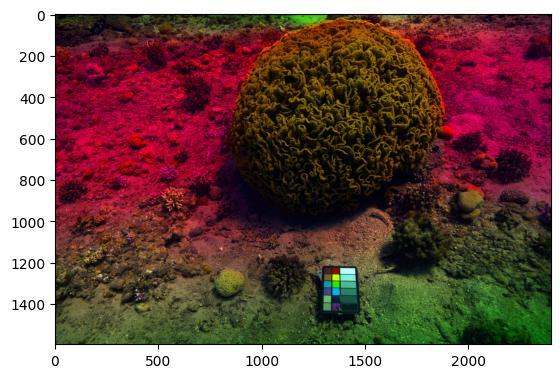

In [ ]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

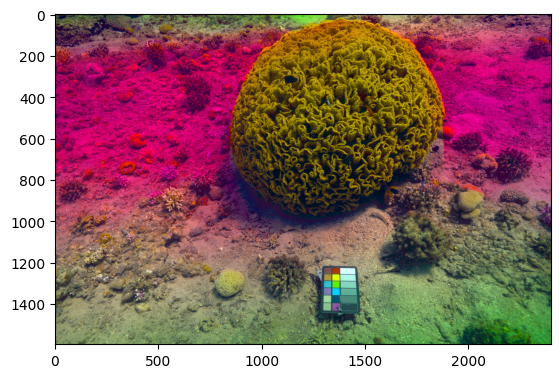

In [ ]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

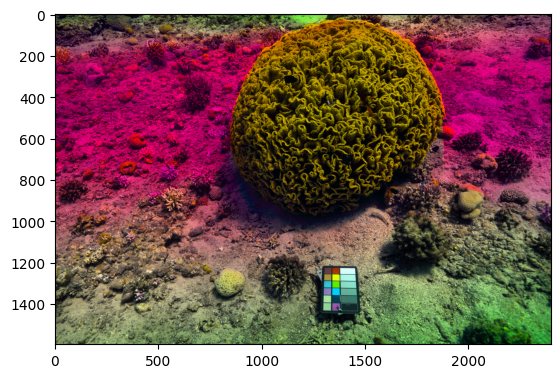

In [ ]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [ ]:
cv2.imwrite("output/crutchfield2_final.png", img_as_ubyte(img_hist))

True